# Fuzzy upravljanje poljoprivrednom proizvodnjom u plasteniku

<center><img src="Tim_Burek_s_Bistrika.jpg" alt="drawing" width="50%"/></center>

### KRATAK OPIS PROBLEMA 
<p>
 Kao što nam je poznato u plastenicima i staklenicima se vrlo brzo mijenjaju klimatski uvjeti
 i zbog toga nam je potrebna automatska regulacija ventilacije kako bi se potpuno iskoristila funkcionalnost objekata.

Zbog previsoke temperature u objektu dolazi do izduživanja internodija na biljkama dok preniska 
temperatura zaustavlja njezin rast. Kod ručnog otvaranja ventilacije nikad ne možemo pravovremeno 
odrediti kada je potrebno otvaranje ili zatvaranje ventilacije, a već mala zakašnjenja mogu dovesti do
 ekstremno visokih temperatura što je veliki šok za biljke.

Sa automatikom se ventilacija vrši postepenim otvaranjem prozora čime se onemogućavaju nagle 
promijene temperature koje uzrokuju šokiranje biljaka. Kod određene brzine i smjera vjetra automatika 
po potrebi pritvara ili zatvara ventilacijske otvore kako bi se spriječilo oštećenje objekta kod nevrjemena.<sup>[1](#izvori)</sup>
</p>

### DEFINICIJA ULAZNIH I IZLAZNIH VARIJABLI

Projekat bi bio realiziran na platformi Raspberry pi pico w, zbog svoje podrške za Python programski jezik i zato što ima ugrađen WiFi čip na sebi koji ćemo iskoristiti u projektu. U nastavku su definisane ulazne i izlazne varijable koje ćemo koristiti za mikrokontroler:

#### Ulazne varijable

Za naš fuzzy kontroler smo koristili 5 ulaznih varijabli:

1. **Varijabla:** Temperatura zraka  
   **Senzor:** `DHT 22`

2. **Varijabla:** Vlažnost zraka  
   **Senzor:** `DHT 22`

3. **Varijabla:** Brzina vjetra  
   **Senzor:** `Adafruit anemometar`

4. **Varijabla:** AQ indeks  
   **API:** [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com) (što je omotač za [AQICN API](https://aqicn.org/city/sarajevo/))

5. **Varijabla:** Da li pada kiša  
   **Senzor:** `Senzor za kišu`


#### Izlazne varijable

Izlazna varijabla je tipa **bool** i predstavlja signal mikrokontroleru da treba otvoriti prozore.

> ili

Izlazna varijabla je tipa **double** i predstavlja koliko će mikrokontroler otvoriti prozore.




### DEFINISANJE FUZZY SKUPOVA

Povrće na koje ćemo se fokusirati u ovom zadatku će biti paradajz pa smo definisali fuzzy skupove prema idealnim uslovima za uzgoj paradajza: 

1. **Varijabla:** Temperatura zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [-40°C, 80°C]<sup>[2](#izvori)</sup>  
   **Lingvistički model varijable:** <sup>[3](#izvori)</sup>  
   - `prehladno`  [-40°C, 16°C]
   - `hladno`  [15°C, 22°C]  
   - `taman-za-noc`  [17°C, 18°C] 
   - `taman-za-dan`  [21°C, 27°C]  
   - `vruće`  [26°C, 35°C]  
   - `prevruće`  [34°C, 80°C]  


2. **Varijabla:** Vlažnost zraka   
   **Tip varijable:** `kontinualna`  
   **Domen:** [0%, 100%]  
   **Lingvistički model varijable:**<sup>[3](#izvori)</sup>  
   - `presuho`    [0%, 50%]  
   - `suho`    [45%, 83%]   
   - `taman-za-noć`    [65%, 75%]  
   - `taman-za-dan`    [80%, 90%]  
   - `prevlažno`  [89%, 100%]   


3. **Varijabla:** Brzina vjetra  
   **Tip varijable:** `kontinualna`   
   **Domen:** [0 m/s, 32.4 m/s]   
   **Lingvistički model varijable:**<sup>[4 5](#izvori)</sup>   
   - `nema`    [0 m/s, 1.4 m/s]  
   - `slab`    [1.3 m/s, 4 m/s]  
   - `umjeren`    [3.5 m/s, 6.7 m/s]  
   - `kritican`    [4.5 m/s, 8.9 m/s]
   - `opasan`  [6.4 m/s, 8.9 m/s ]  
   - `jako-opasan`  [14.5 m/s, 32.4 m/s ]  

4. **Varijabla:** AQ indeks  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0, +∞)  
   **Lingvistički model varijable:**<sup>[5](#izvori)</sup>
   - `dobro`    [0, 50]  
   - `umjereno`    [51, 100]  
   - `blago nezdravo`    [101, 150]  
   - `nezdravo`    [151, 200]  
   - `pravo nezdravo`    [201, 300]  
   - `opasno`  [301, +∞)  

5. **Varijabla:** Da li pada kiša  
   **Tip varijable:** `diskretna`  
   **Domen:** {0, 1}  
   **Lingvistički model varijable:**  
   - `ne pada kiša`  {0}  
   - `pada kiša`  {1}

6. **Varijabla:** Vrijeme dana  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0,24)  
   **Lingvistički model varijable:**  
   - `noć` [0, 7]U[19, 24)  
   - `jutro` [6,12]  
   - `podne` [11,13]  
   - `poslijepodne` [12, 20]    

Također ćemo definisati skup za rezultujuću varijablu, koja predstavlja šta će prozor uraditi:

1. **Varijabla:** prozor  
   **Tip varijable:** `Kontinualna`  
   **Domen:** [0,1]  
   **Lingvistički model varijable:**  
   - `zatvori` [0, 0.3]  
   - `nista ne radi` [0.2, 0.4]  
   - `otvori` [0.3, 1]  

> Napomena: Iako `otvori` ima veći domen od `zatvori`, ona može dostići samo do vrijednosti 0.6


### IZRADA FUZZY PRAVILA

1. Ako je vrijeme dana noć i temperatura zraka taman-za-noć i vlažnost zraka taman-za-noć i brzina vjetra slab i AQ indeks dobro, otvori prozor


____
1. Ako je vrijeme dana noć i temperatura zraka taman-za-dan, otvori prozor
1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-noć, zatvori prozor
1. Ako je temperatura zraka prehladno ili je temperatura hladno, zatvori prozor
1. Ako je temperatura vruće ili je temperatura prevruće, otvori prozor

1. Ako je vrijeme dana noć i temperatura je taman-za-noć, ne radi ništa
1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-dan, ne radi ništa

1. Ako je vlažnost zraka presuho, otvori prozor
1. Ako je vlažnost zraka suho, otvori prozor
1. Ako je vlažnost prevlažno i ne pada kiša, otvori prozor


1. Ako je brzina vjetra nije nema i brzina vjetra nije slab i brzina vjetra nije umjeren, zatvori prozor
1. Ako je brzina vjetra slab i vlažnost je suha ili vlažnost je presuha, otvori prozor
1. Ako je brzina vjetra nije nema i vlažnost zraka nije taman-za-noć ili vlažnost zraka nije taman-za-dan, zatvori prozor

1. Ako AQ indeks nije dobro ili AQ indeks nije umjereno, zatvori prozor

__  



1. Ako je jak vjetar, zatvori
1. Ako umjeren vjetar i vlažan zrak, 
1. Ako je temperatura visoka, otvori
1. Ako je brzina vjetra jak, zatvori
1. Ako je AQI nezdravo, zatvori
1. Ako je AQI pravo nezdravo, zatvori
1. Ako je AQI opasno, zatvori
1. Ako pada kiša i suho, otvori
1. Ako pada kiša i vlažno, otvori
1. Ako vruće i pada kiša, otvori

```cpp
temp> -> otvori
temp< -> zatvori

brzina vjetra> -> zatvori
brzina vjetra< -> otvori~~

vlažnost zrala> -> otvori
vlažnost zraka< -> zatvori

AQI> -> zatvori
AQI< -> otvori ###

pada kiša i vlažnost< -> otvori?
pada kiša i vlažnost> -> zatvori?
ne pada kiša i vlažnost> -> otvori?
ne pada kiša i vlažnost< -> otvori?
ne pada kiša i vlažnost== -> zatvori?

Ako temp> i pada kiša -> otvori

balansiramo temp i vlažnost~~```



AQI < pada kiša < brzina vjetra < vlažnost zrala < temp
AQI > brzina vjetra > temperatura > vlaga > kiša > vrijeme dana 
Cilj: drzi prozore sto je duze otvorene.




### IMPLEMENTACIJA FUZZY SISTEMA i PRIKAZ REZULTATA

U nastavku imamo 3 python koda:

1. kod za server
1. kod za mikrokontroler
1. kod za funkciju koja računa fuzzy logiku

Prva 2 koda se neće moći i ne smiju pokrenuti iz notebooka, jer nisu dizajnirani da se mogu završiti u njemu. Kod za server se izvršava na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com), a kod za mikro kontroler se izvršava na mikrokontroleru Raspberry pi pico w, čiju simulaciju možete pogledati [ovdje](https://wokwi.com/projects/432770743981576193). Pošto je komunikacija između server i simulacije relativno spora, u nastavku će biti i verzija koda (demonstracije), koja se može pokrenuti direktno na notebooku. Zato su kod za server i mikrokontroler zapisani u markdown čelijama, kako bi se mogli samo gledati, ali ne i izvršavati.

Kod za server na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com):

```python

import requests
from flask import Flask, request, jsonify
import fuz
print("ok")
app = Flask(__name__)

with open("/home/fuzzypico/mysite/.secret", "r") as secret:
    WAQI_TOKEN = secret.read()
WAQI_URL_TEMPLATE = 'https://api.waqi.info/feed/{}/?token={}'

@app.route('/')
def hello_world():
    return ' fuzzypico.pythonanywhere.com/AQI [POST] {"grad":"sarajevo"} | fuzzypico.pythonanywhere.com/paradajz_fuzzy [POST] {"grad":"sarajevo"} '

@app.route('/QT')
def QuTe():
    return "QuTe"

@app.route('/AQI', methods=['POST'])
def get_air_quality():
    data = request.get_json()

    if not data or 'grad' not in data:
        return jsonify({'error': 'Missing "grad" in request'}), 400

    grad = data['grad'].strip().lower()
    url = WAQI_URL_TEMPLATE.format(grad, WAQI_TOKEN)

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        aqi = data["data"]["aqi"]
        return jsonify({"aqi": aqi})
        return jsonify(response.json())
    except requests.RequestException as e:
        return jsonify({'error': 'Failed to fetch data from WAQI API', 'details': str(e)}), 500

@app.route('/paradajz_fuzzy', methods=['POST'])
def calc_fuzzy():
    print("Form data:", request.form)
    vektor = []
    try:
        vektor.append(float(request.form['TemperaturaZraka']))
        vektor.append(float(request.form['VlaznostZraka']))
        vektor.append(float(request.form['BrzinaVjetra']))
        vektor.append(int(request.form['AQI']))
        vektor.append(int(request.form['DaLiPadaKisa']))
        vektor.append(float(request.form['VrijemeDana']))
    except Exception as e:
        return jsonify({"ERROR":str(e)}), 500
    val, zatvori, otvori, nista = fuz.paradajz_fuzzy(vektor)
    #"povrce":"paradajz",
    return jsonify({"fuzzy": val, "zatvori": zatvori, "otvori": otvori, "nista":nista})


```

U nastavku je kod za mikrokontroler

```python
import time
from machine import Pin, ADC, PWM
import dht
time.sleep(0.1) # Wait for USB to become ready

print("Hello, Pi Pico W!")
time.sleep(1)
print("Molim vas pricekajte.")

pin = Pin(23,Pin.OUT)
pin.value(1)

# definicija pinova
doba_a_dana = ADC(27)
brz_a_vjet = ADC(26)
pada_d_kisa = Pin(18, Pin.IN, Pin.PULL_UP)
dht22 = dht.DHT22(Pin(17))

servo_d_pin = Pin(0)
max_duty = 7864
min_duty = 1802
frequency = 50
servo = PWM(servo_d_pin)
servo.freq (frequency)

racunaj_d_fuzzy = Pin(4, Pin.IN, Pin.PULL_UP)

led = Pin(10, Pin.OUT)
#input_d = Pin(16, Pin.IN, Pin.PULL_UP)
v=True

temp = 0
vlaz = 0
brz_vjet = 0
aqi = 0
vri_dana = 0
da_li_pada_kisa = False

def get_button(button):
    return not button.value()

def get_potmtr(potmtr):
    return potmtr.read_u16()

def get_potmtr_scaled(pot, low, high):
    raw = pot.read_u16()  # Range: 0–65535
    scaled = low + (raw / 65535) * (high - low)
    return scaled

def ispis():
    global temp 
    global vlaz 
    global brz_vjet 
    global aqi 
    global da_li_pada_kisa 
    global vri_dana 
    #global rtc
    print()
    #print("RTC: ",rtc.datetime())
    print("Temperatura:", temp)
    print( "Vlaznost zraka:", vlaz)
    print("Brzina vjetra:",brz_vjet)
    print( "AQ indeks:", aqi)
    print("Doba dana:", vri_dana)


import network
import urequests
import ujson

print("Spajanje na WiFi", end="")
wlan = network.WLAN(network.STA_IF)
wlan.active(True)
wlan.connect("Wokwi-GUEST", "")
#wlan.connect('Bbox-0488C286', 'Ua5fxZpMraJLdLF3jE')
while not wlan.isconnected():
  print(".", end="")
  time.sleep(0.1)
print(" Konektovan!\nProzor je zatvoren.")
servo.duty_u16(min_duty)
time.sleep(.2)
print(wlan.ifconfig())

def post_request_aqi(url, grad):
    """
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    payload = "&"
    """
    r = requests.post(url, json={"grad": grad})
    print(r.json())

def post_request_fuzzy(url, vektor):
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    form_data = {
        "TemperaturaZraka":vektor[0],
        "VlaznostZraka":vektor[1],
        "BrzinaVjetra":vektor[2],
        "AQI":vektor[3],
        "DaLiPadaKisa":vektor[4],
        "VrijemeDana":vektor[5]
    }
    # Convert dict to URL-encoded string: key1=value1&key2=value2...
    payload = "&".join(f"{k}={v}" for k, v in form_data.items())

    try:
        print("Salje se zahtjev ka",url)
        response = urequests.post(url, data=payload, headers=headers)
        print(response)
        result = response.text#response.json()
        response.close()
        return result
    except Exception as e:
        print("POST failed:", e)
        return {"error": str(e)}

print("Spreman. Namjestite vrijednosti pa pritisnite crveno dugme.")
print("Ako vam se ne registruje pritisak dugmeta, pritisnite ga ponovno.")

while True:
    dht22.measure() 
    # citaj doba dana
    vri_dana = get_potmtr_scaled(doba_a_dana, 0, 24)

    # citaj brzinu vjetra
    brz_vjet = get_potmtr_scaled(brz_a_vjet, 0, 32.4)

    # citaj da li pada kisa
    if get_button(pada_d_kisa) == 1:
        da_li_pada_kisa = not da_li_pada_kisa
        led.value(da_li_pada_kisa)

    # citaj vlaznost zraka
    vlaz=dht22.humidity()

    # Citaj temperaturu zraka
    temp=dht22.temperature()

    # Računaj fuzzy
    if get_button(racunaj_d_fuzzy) == 1:
        ispis()
        rez_dict=post_request_fuzzy(
            "https://fuzzypico.pythonanywhere.com/paradajz_fuzzy",
            [temp,vlaz,brz_vjet,aqi, int(da_li_pada_kisa),vri_dana]
        )
        print(rez_dict,"\n")
        rez_dict = ujson.loads(rez_dict)
        izbor = max(rez_dict, key=rez_dict.get)
        print("Prozor ce biti ", izbor)
        if izbor == "otvori":
            print("Prozor se otvara")
            servo.duty_u16(max_duty)
            time.sleep(2)
            pass
        elif izbor == "zatvori":
            print("Prozor se zatvara")
            servo.duty_u16(min_duty)
            time.sleep(2)
            pass
        else:
            print("Prozor ostaje kakav je bio")
            pass

    # Citaj AQI
    time.sleep(.1)
```

Sad će biti definisana funkcija `paradajz_fuzzy(vektor)`, koju server poziva da bi dobio rezultate koje bi proslijedio mikrokontroleru. Da bi se naredne čelije mogle pokretati, neophodno je pokrenuti narednu.

In [24]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import json

with open("paradajz.json", "r") as json_file:
    paradajzDict = json.load(json_file)

def paradajz_fuzzy(vektor):
    #print(vektor)
    val = 0

    # Define input variables
    lista_inputa = []
    for uvjet in paradajzDict["uvjeti"]:
        od = uvjet["Domen"][0]
        do = uvjet["Domen"][1]
        delta = uvjet["Domen"][2]
        lista_inputa.append(ctrl.Antecedent(np.arange(od,do,delta), uvjet["Varijabla"]))



    # Define output variable with more points
    prozor = ctrl.Consequent(np.arange(0, 1.1, 0.5), 'prozor')

    # Membership functions
    for i in range(len(lista_inputa)):
        lin_var = paradajzDict["uvjeti"][i]["Lingvisticki model varijable"]
        for e in lin_var:
            if e["ime"]=="noc":
                noc_morning = fuzz.trapmf(lista_inputa[i].universe, e["domen"][0])
                noc_evening = fuzz.trapmf(lista_inputa[i].universe, e["domen"][1])
                lista_inputa[i][e["ime"]] = np.fmax(noc_morning, noc_evening)
            elif len(e["domen"])==3:
                lista_inputa[i][e["ime"]]= fuzz.trimf(lista_inputa[i].universe, e["domen"])
            elif len(e["domen"])==4:
                lista_inputa[i][e["ime"]]= fuzz.trapmf(lista_inputa[i].universe, e["domen"])

    #prozor['zatvori'] = fuzz.trimf(prozor.universe, [0, 0, 0.5])
    #prozor['nista ne radi'] = fuzz.trimf(prozor.universe, [0.4, 0.5, 0.6])
    #prozor['otvori'] = fuzz.trimf(prozor.universe, [0.5, 1, 1])
    prozor = ctrl.Consequent(np.arange(0, 1.001, 0.001), 'prozor')
    prozor['zatvori'] = fuzz.trimf(prozor.universe, [0, 0, 0.3])
    prozor['nista ne radi'] = fuzz.trimf(prozor.universe, [0.15, 0.16, 0.4])
    prozor['otvori'] = fuzz.trapmf(prozor.universe, [0.3, 0.6, 1, 1])

    #prozor.view()

    temperatura = lista_inputa[0]
    vlaznost = lista_inputa[1]
    brzinaVjetra = lista_inputa[2]
    aqi = lista_inputa[3]
    daLiKisaPada = lista_inputa[4]
    vrijemeDana = lista_inputa[5]
    # Rules
    pravila = []
    #pravila.append(ctrl.Rule())
    """pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"]) & temperatura['vruce'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(~aqi["dobro"] & ~aqi["umjereno"],prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-noc'] & vlaznost["suho"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['vruce'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['hladno'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-dan'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & brzinaVjetra["umjeren"] & temperatura['taman-za-dan'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['vruce'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-noc'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-dan'] & vlaznost["taman-za-noc"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & daLiKisaPada["pada kisa"] & brzinaVjetra["opasan"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prevruce"] & vrijemeDana["podne"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['opasno'], prozor["zatvori"]))
    pravila.append(ctrl.Rule(daLiKisaPada["pada kisa"] & brzinaVjetra["jako-opasan"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura["prehladno"] & vrijemeDana["noc"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(vlaznost["prevlazno"] & temperatura["hladno"] & vrijemeDana["jutro"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi["pravo nezdravo"] & daLiKisaPada["pada kisa"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura["prevruce"] & vrijemeDana["podne"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(brzinaVjetra["kritican"] & temperatura["hladno"] & vrijemeDana["noc"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi["blago nezdravo"] & vlaznost["prevlazno"] & vrijemeDana["poslijepodne"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(brzinaVjetra["opasan"] & daLiKisaPada["pada kisa"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi["nezdravo"] & temperatura["taman-za-dan"] & ~daLiKisaPada["ne pada kisa"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["hladno"] & vlaznost["prevlazno"] & vrijemeDana["jutro"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prehladno"] & brzinaVjetra["slab"] & vrijemeDana["noc"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["prevruce"] & vlaznost["prevlazno"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & vlaznost["prevlazno"] & vrijemeDana["noc"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & daLiKisaPada["pada kisa"] & temperatura["hladno"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prehladno"] & vlaznost["presuho"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & brzinaVjetra["jako-opasan"], prozor["zatvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["taman-za-dan"] & daLiKisaPada["pada kisa"] & vlaznost["prevlazno"], prozor["zatvori"]))
    """
    """pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"]) & temperatura['vruce'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(~aqi["dobro"] & ~aqi["umjereno"],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-noc'] & vlaznost["suho"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['vruce'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['hladno'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-dan'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & brzinaVjetra["umjeren"] & temperatura['taman-za-dan'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['vruce'] & vlaznost["suho"] & ~daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-noc'] & vlaznost["taman-za-dan"] & daLiKisaPada["ne pada kisa"] & vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & (brzinaVjetra["slab"] | brzinaVjetra["nema"])  & temperatura['taman-za-dan'] & vlaznost["taman-za-noc"] & daLiKisaPada["ne pada kisa"] & ~vrijemeDana['noc'],prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & daLiKisaPada["pada kisa"] & brzinaVjetra["opasan"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prevruce"] & vrijemeDana["podne"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(aqi['opasno'], prozor["zatvori"]))#
    
    pravila.append(ctrl.Rule(daLiKisaPada["pada kisa"] & brzinaVjetra["jako-opasan"], prozor["otvori"]))
    pravila.append(ctrl.Rule(temperatura["prehladno"] & vrijemeDana["noc"], prozor["otvori"]))
    pravila.append(ctrl.Rule(vlaznost["prevlazno"] & temperatura["hladno"] & vrijemeDana["jutro"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi["pravo nezdravo"] & daLiKisaPada["pada kisa"], prozor["otvori"]))
    pravila.append(ctrl.Rule(temperatura["prevruce"] & vrijemeDana["podne"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(brzinaVjetra["kritican"] & temperatura["hladno"] & vrijemeDana["noc"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi["blago nezdravo"] & vlaznost["prevlazno"] & vrijemeDana["poslijepodne"], prozor["otvori"]))
    pravila.append(ctrl.Rule(brzinaVjetra["opasan"] & daLiKisaPada["pada kisa"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi["nezdravo"] & temperatura["taman-za-dan"] & ~daLiKisaPada["ne pada kisa"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["hladno"] & vlaznost["prevlazno"] & vrijemeDana["jutro"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prehladno"] & brzinaVjetra["slab"] & vrijemeDana["noc"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["prevruce"] & vlaznost["prevlazno"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & vlaznost["prevlazno"] & vrijemeDana["noc"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(aqi['umjereno'] & daLiKisaPada["pada kisa"] & temperatura["hladno"], prozor["otvori"]))#
    pravila.append(ctrl.Rule(aqi['dobro'] & temperatura["prehladno"] & vlaznost["presuho"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['dobro'] & brzinaVjetra["jako-opasan"], prozor["otvori"]))
    pravila.append(ctrl.Rule(aqi['umjereno'] & temperatura["taman-za-dan"] & daLiKisaPada["pada kisa"] & vlaznost["prevlazno"], prozor["otvori"]))
    """
    
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor["otvori"]))
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-noc'], prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['prehladno'] | temperatura['hladno'],prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['vruce'] | temperatura['prevruce'],prozor["otvori"]))
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor['nista ne radi']))
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & temperatura['taman-za-noc'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & vlaznost['taman-za-dan'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & vlaznost['taman-za-noc'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(vrijemeDana['podne'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(vlaznost['presuho'],prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['suho'], prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['prevlazno'] & ~daLiKisaPada["ne pada kisa"], prozor['otvori']))
    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & ~brzinaVjetra["slab"], prozor['zatvori']))
    pravila.append(ctrl.Rule(brzinaVjetra["slab"] & (vlaznost["suho"] | vlaznost["presuho"]), prozor['otvori']))
    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & (~vlaznost["taman-za-dan"] | ~vlaznost["taman-za-noc"]), prozor['zatvori']))
    #pravila.append(ctrl.Rule(~aqi["dobro"] | ~aqi["umjereno"],prozor["zatvori"]))
    pravila.append(ctrl.Rule(~(aqi["dobro"] | aqi["umjereno"]),prozor["zatvori"]))
    
    #for pravilo in pravila:
    #    aktivacija = pravilo.antecedent.evaluate(kontroler.input)
    #    if aktivacija > 0:
    #        print("Aktivirano pravilo:", pravilo)

    # Control system
    window_ctrl = ctrl.ControlSystem(pravila)
    window_sim = ctrl.ControlSystemSimulation(window_ctrl)

    # Set inputs

    #window_sim.input['temperature'] = 60
    #window_sim.input['humidity'] = 10
    i=0
    for e in paradajzDict["uvjeti"]:
        window_sim.input[e["Varijabla"]] = vektor[i]
        i+=1
    #window_sim.input["TemperaturaZraka"] = vektor[3]
    # Compute
    window_sim.compute()
    val = window_sim.output['prozor']


    #for pravilo in window_sim.ctrl.rules:
    #    print(f"Rule: {pravilo}")
    #    print(f"Firing strength: {pravilo.firing_strength}")
    prozor.view(sim=window_sim)
    temperatura.view(sim=window_sim)
    vlaznost.view(sim=window_sim)
    brzinaVjetra.view(sim=window_sim)
    aqi.view(sim=window_sim)
    daLiKisaPada.view(sim=window_sim)
    vrijemeDana.view(sim=window_sim)
    #Views
    #for e in lista_inputa:
    #    e.view()
    #print("Window state (0=closed, 1=open):", val)

    mu_zatvori = fuzz.interp_membership(prozor.universe, prozor['zatvori'].mf, val)
    mu_otvori = fuzz.interp_membership(prozor.universe, prozor['otvori'].mf, val)
    mu_nista = fuzz.interp_membership(prozor.universe, prozor['nista ne radi'].mf, val)
    #mu_zatvori=0

    return val, mu_zatvori, mu_otvori, mu_nista

def ispis(fuzzy, zatvori, otvori, nista):
    print("fuzzy:",fuzzy)
    print("zatvori:",zatvori)
    print("otvori:",otvori)
    print("nista:",nista)



Ovdje ćemo demonstrirati jedan scenario gdje će se prozori zatvoriti, jer je temperatura zraka prehladna.

fuzzy: 0.09999999999999992
zatvori: 0.666666666666667
otvori: 0.0
nista: 0.0


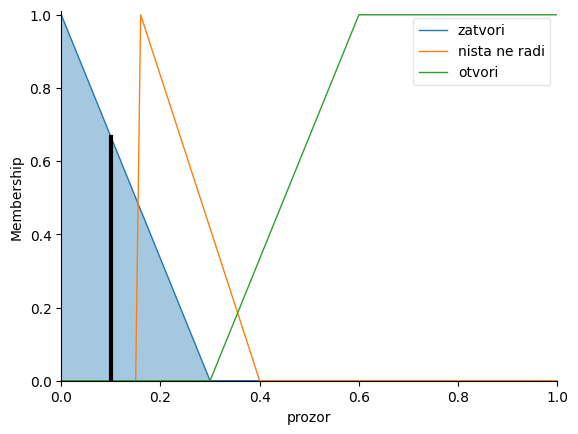

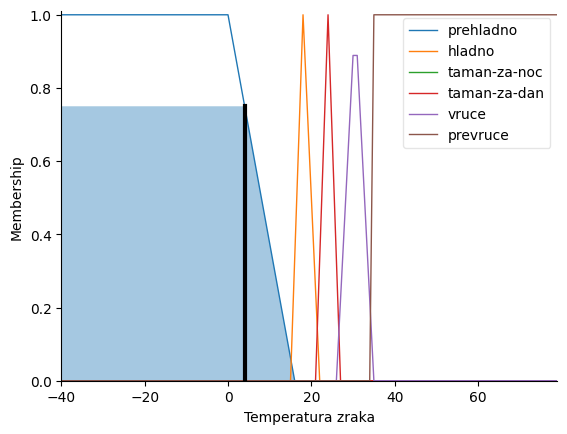

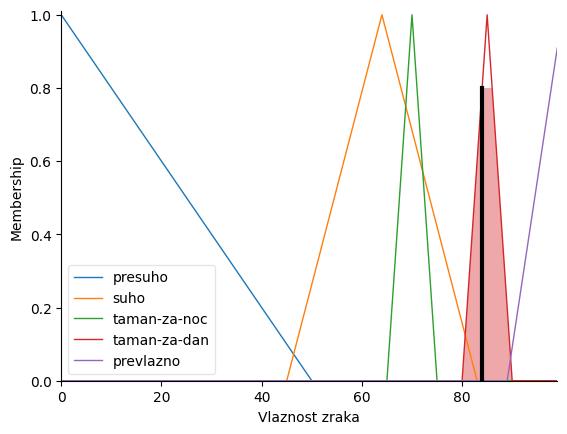

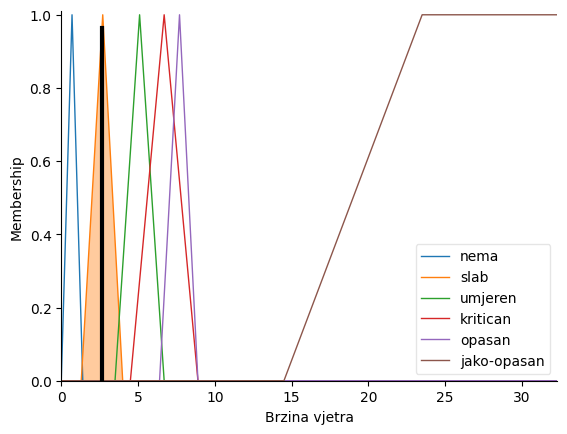

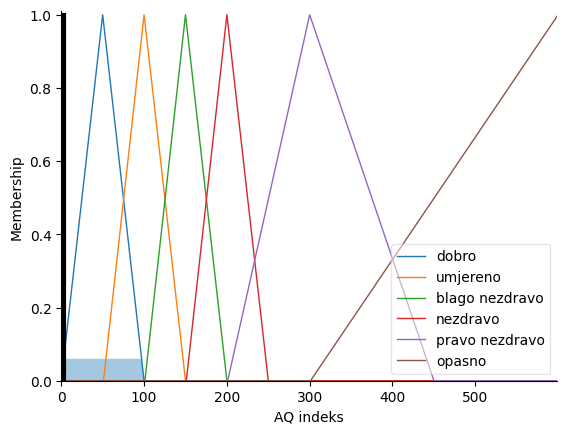

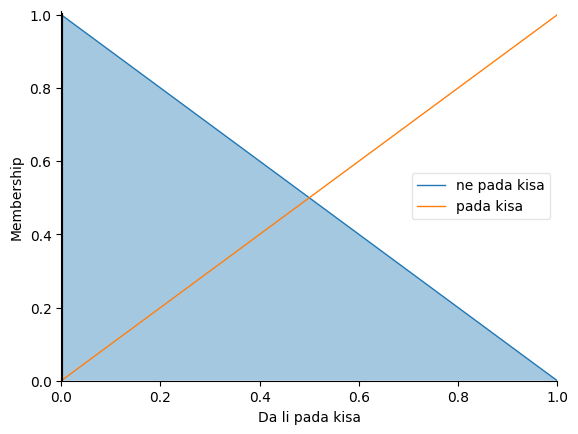

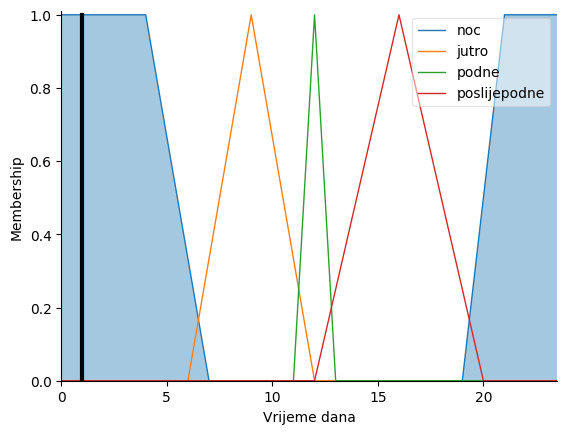

In [27]:
varijable = {
    "TemperaturaZraka":4,
    "VlaznostZraka":84,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":1,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

Ovdje ćemo demonstrirati jedan scenario gdje će se prozori otvoriti, jer je vrijeme dana noć, a temperatura zraka je taman za dan.

fuzzy: 0.5857142857142856
zatvori: 0.0
otvori: 0.9523809523809521
nista: 0.0


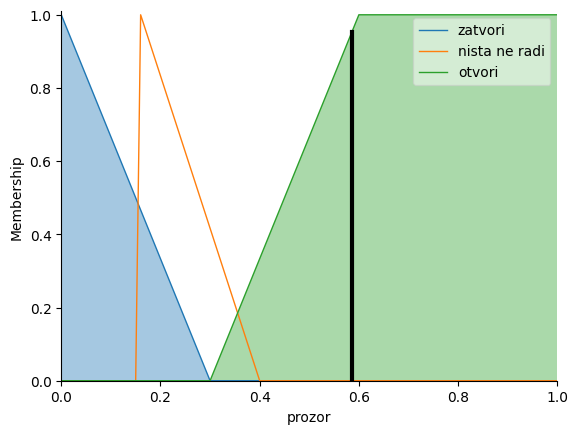

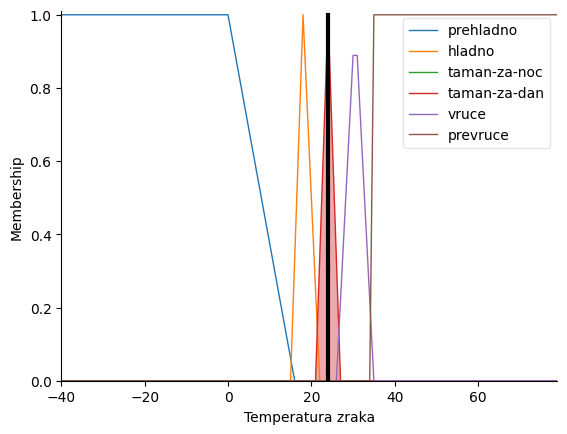

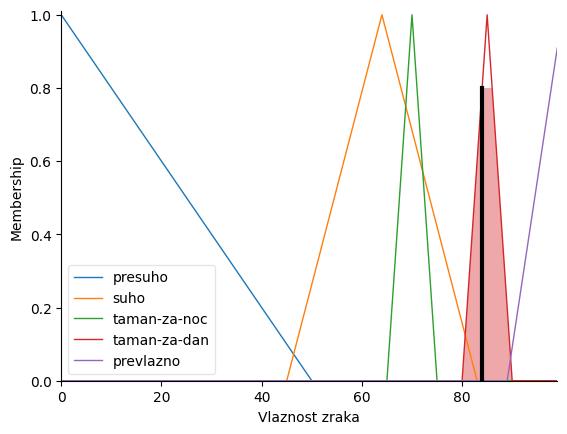

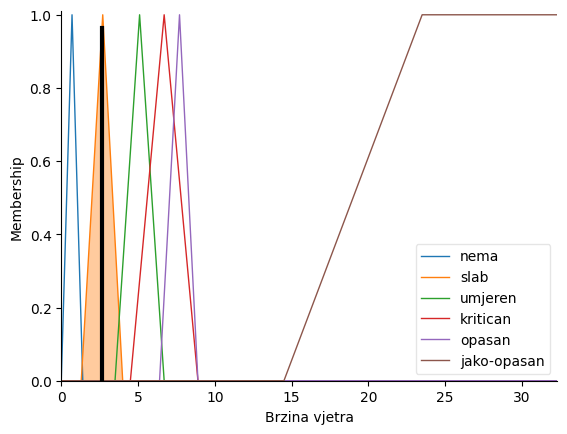

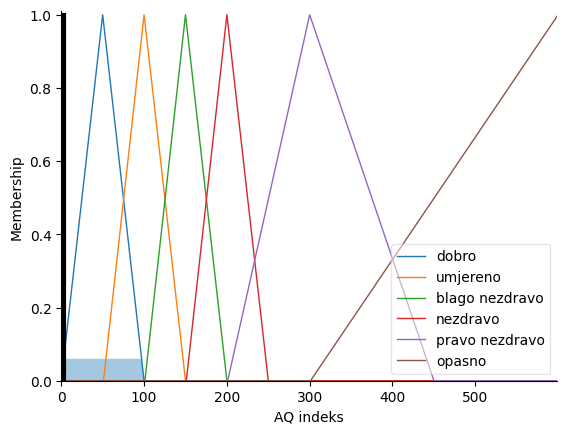

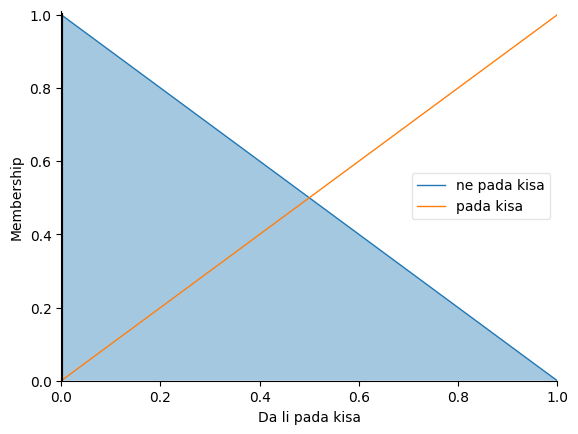

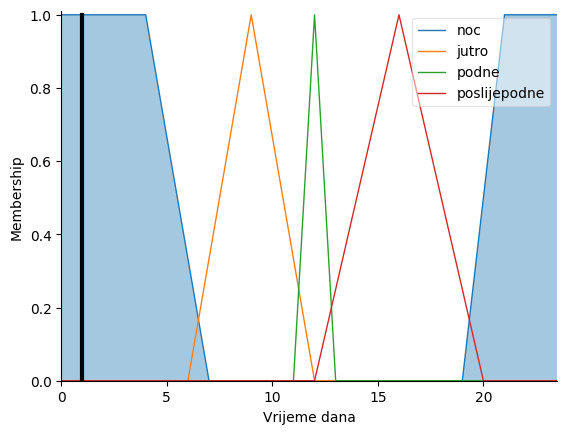

In [26]:
varijable = {
    "TemperaturaZraka":24,
    "VlaznostZraka":84,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":1,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

Ovdje ćemo demonstrirati jedan scenario gdje će prozori ostati u svom trenutnom stanju, jer temperatura i vlažnost zraka odgovaraju trenutnom dubu dana.

fuzzy: 0.15611736368079304
zatvori: 0.4796087877306898
otvori: 0.0
nista: 0.6117363680793042


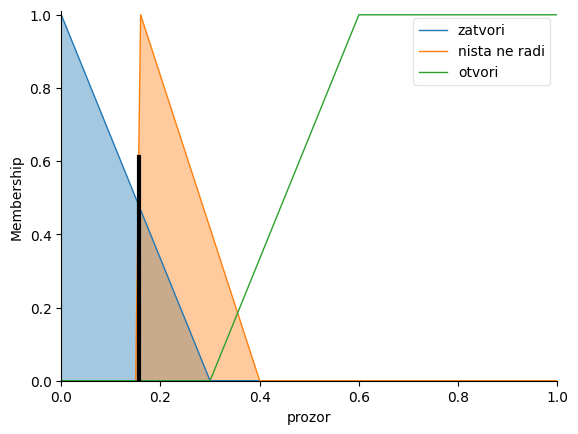

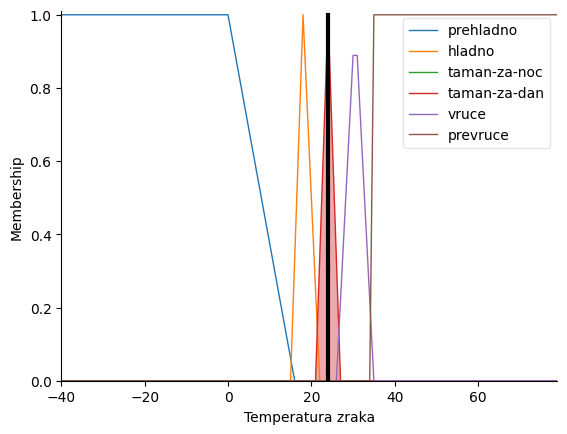

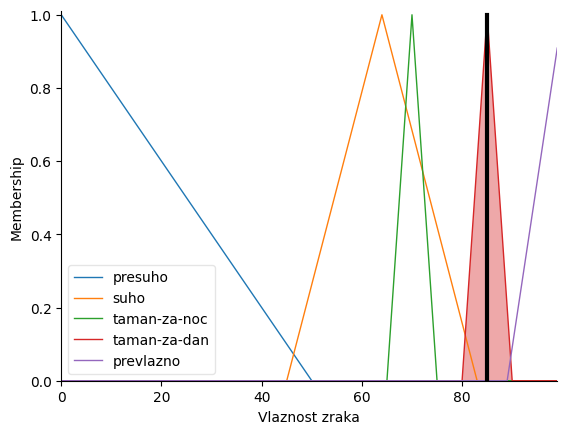

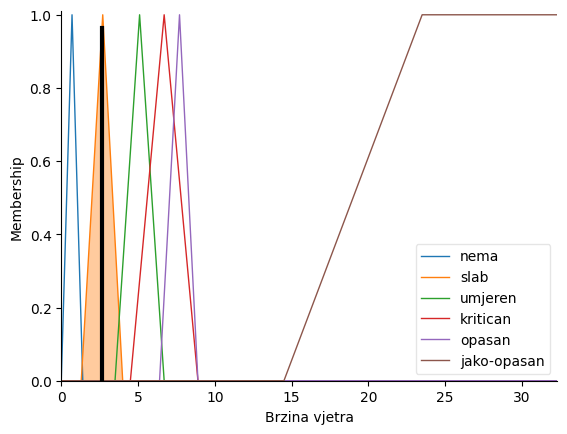

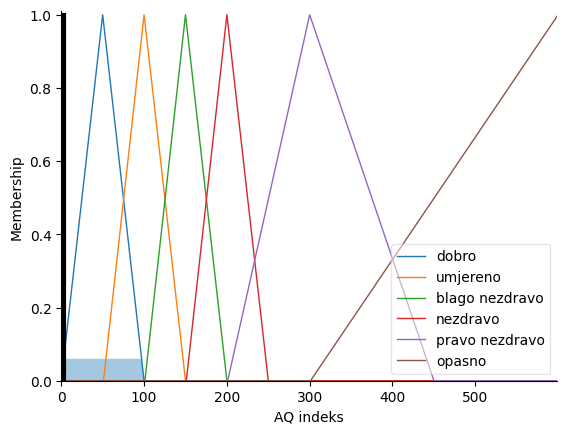

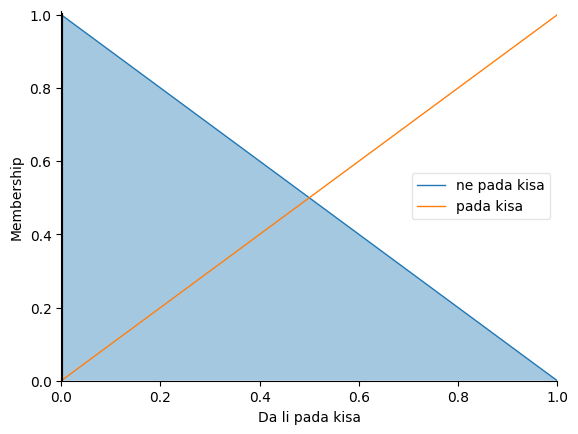

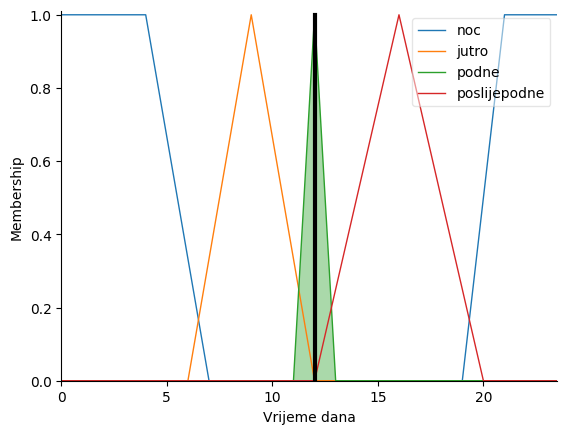

In [25]:
varijable = {
    "TemperaturaZraka":24,
    "VlaznostZraka":85,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":12,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

### ZAKLJUČAK I KRATKA REFLEKSIJA

### IZVORI

1. https://www.winter.hr/automatika.htm
1. https://cdn.sparkfun.com/assets/f/7/d/9/c/DHT22.pdf
1. https://cales.arizona.edu/hydroponictomatoes/system.htm
1. https://www.weather.gov/pqr/wind
1. https://stellinamarfa.com/fruits/how-much-wind-is-too-much-for-tomato-plants/
1. https://waqi.info/#/c/3.396/8.206/2.2z






### ULOGE ČLANOVA

Aid Mustafić - Uvod i zaključak
Adnan Muradbegović - Definicija Skupova fuzzy logike
Tarik Ređić - Dizajniranje pravila rezonovanja fuzzy logike
Zlatan Ljutika - Razvijanje serverskog i mikrokontrolerskog koda